In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from requests import get
from datetime import datetime, timedelta
import yfinance as yf

from pytrends.request import TrendReq
pytrend = TrendReq() #login

# get_name()

In [2]:
def get_name(symbol):
    '''retrieve company name from a ticker, using Yahoo finance (since we use yfinance API)
    inspired by starckoverflow 38967533'''
    symbol = symbol.upper()
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    data = requests.get(url).json()
    for x in data['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']
    raise KeyError("No company listed under that symbol")

# example/BTC

In [3]:

pytrend.build_payload(kw_list=['stock'], cat=0, timeframe='today 5-y', geo='', gprop='') #creating payload  -> only for interest_over_time(), interest_by_region() & related_queries()
interest_over_time_sp = pytrend.interest_over_time()

pytrend.build_payload(kw_list=['bonds'], cat=0, timeframe='today 5-y', geo='', gprop='') #creating payload  -> only for interest_over_time(), interest_by_region() & related_queries()
interest_over_time_bd = pytrend.interest_over_time()

plt.figure(figsize=(15,7))
plt.title("interest over time")
plt.plot(interest_over_time_sp["stock"], label="stock")
plt.plot(interest_over_time_bd["bonds"], label="bond")
plt.show()

SyntaxError: invalid syntax (<ipython-input-3-5f35b38ff620>, line 11)

# google trends vs MA function

In [4]:
def gtrend_vs_ma(ticker, topic, start=datetime.today() - timedelta(days=90), end=datetime.today(), use_sugg=True):
    '''take a ticker and a topic (ie company's name) as string, and a optionnal start/end date (must be 3m to stay at daily
    granularity though). Use_sugg implies using the officiel Google comùpany suggestion, if set to False, the topic 
    is used "as it"
    
    print the 3 graphs and return stock_df and interest_df'''
    #need a fix using topic=get_name(ticker) for large scale automation
    #(but buggy since topics are not standardized), ie : get_name(appl) returns "Apple inc", and GTrends suggest "Apple"
    #only for tech company (and Apple Inc. for the texan factory...)

    #download prices:
    stock_df = yf.download(ticker, start=start, end=end)


    #determine best Google search term (ie the company associated):
    if use_sugg :
        sugg = pd.DataFrame(pytrend.suggestions(topic))
        if sugg["type"].str.contains("company", case=False).sum() == 0:
            raise ValueError("No company suggestion in Google Trends")
        elif sugg["type"].str.contains("company", case=False).sum() > 1:
            raise ValueError("More than one company suggestion in Google Trends")
        else:
            sugg = sugg[sugg["type"].str.contains("company", case=False)]["mid"]
    else:
        sugg = [topic]

    #retrieve the trend associated with that term:
    pytrend.build_payload(kw_list=sugg, cat=0, timeframe='today 3-m', geo='', gprop='')
    interest_over_time_df = pytrend.interest_over_time()

    #plot
    fig, ax1 = plt.subplots(figsize=(15,7))
    plt.grid(True)

    ax1.set_title("interest vs price - {}".format(ticker))
    ax1.set_xlabel("Date")

    ax1Color = "blue"
    ax1.set_ylabel("interest", color=ax1Color)
    l1, = ax1.plot(interest_over_time_df[sugg], color=ax1Color)
    ax1.tick_params(axis="y", color=ax1Color)

    ax2 = ax1.twinx()
    ax2Color = "red"
    ax2.set_ylabel("price", color=ax2Color)
    l2, = ax2.plot(stock_df["Close"], color=ax2Color)
    ax2.tick_params(axis="y", color=ax2Color)

    fig.legend([l1, l2], ["\"{}\" interest".format(topic), ticker], loc = "upper right",
               bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes) #bbox_to_anchor = (0.07, 0.8))
    plt.show()

    #compute moving average :
    #first,expand the window so as to have enough data on the inital timeframe (assuming end is today)
    #then compute MM and send it for plotting

    plt.figure(figsize=(15,7))
    plt.title("Moving averages - {}".format(ticker))
    plt.grid(True)

    for i in [7, 21, 50]:
        startTmp = start - timedelta(days=i*2)
        stockTmp = yf.download(ticker, start=startTmp, end=end)
        plt.plot(stockTmp["Close"].rolling(window=i).mean()[start:], label="{} days MA".format(i))
    plt.legend()
    plt.show()
    
    return stock_df, interest_over_time_df

# Apple

[*********************100%***********************]  1 of 1 completed


/home/simon/anaconda3/envs/daily/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


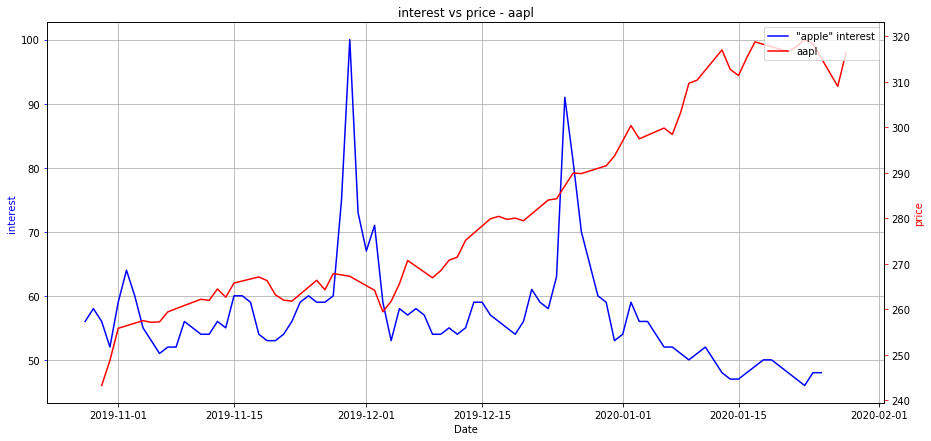

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


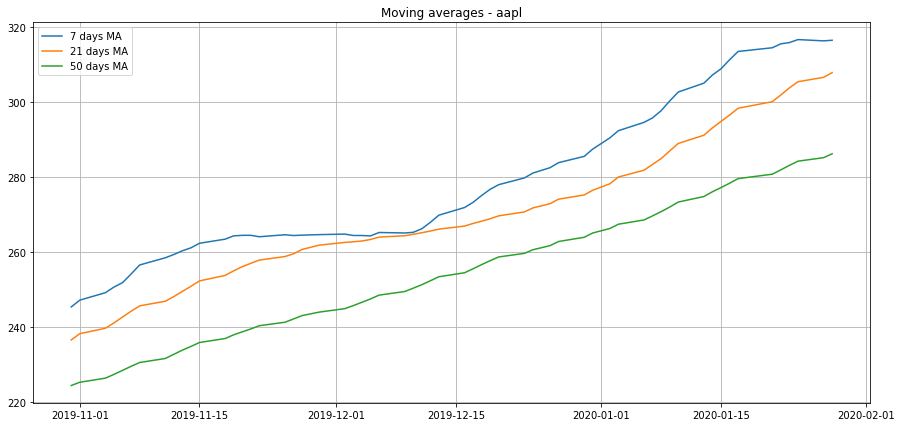

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-10-30  244.759995  245.300003  241.210007  243.259995  242.531845   
 2019-10-31  247.240005  249.169998  237.259995  248.759995  248.015381   
 2019-11-01  249.539993  255.929993  249.160004  255.820007  255.054260   
 2019-11-04  257.329987  257.850006  255.380005  257.500000  256.729218   
 2019-11-05  257.049988  258.190002  256.320007  257.130005  256.360352   
 ...                ...         ...         ...         ...         ...   
 2020-01-22  318.579987  319.989990  317.309998  317.700012  317.700012   
 2020-01-23  317.920013  319.559998  315.649994  319.230011  319.230011   
 2020-01-24  320.250000  323.329987  317.519989  318.309998  318.309998   
 2020-01-27  310.059998  311.769989  304.880005  308.950012  308.950012   
 2020-01-28  312.600006  316.769989  312.190002  316.390015  316.390015   
 
               Volume  

In [5]:
gtrend_vs_ma("aapl", "apple")

# facebook

[*********************100%***********************]  1 of 1 completed


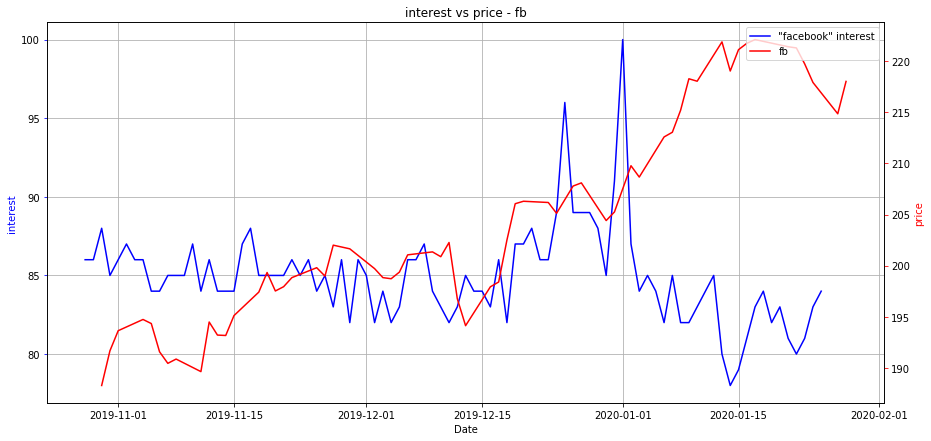

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


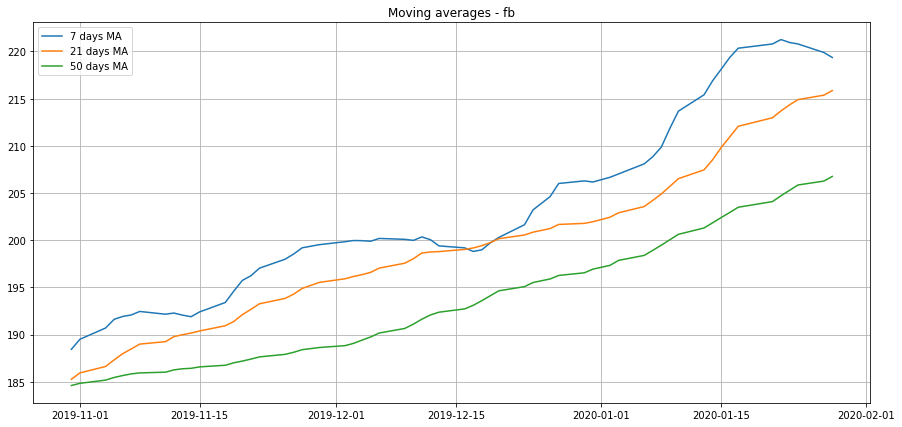

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-10-30  189.559998  190.449997  185.979996  188.250000  188.250000   
 2019-10-31  196.699997  198.089996  188.250000  191.649994  191.649994   
 2019-11-01  192.850006  194.110001  189.910004  193.619995  193.619995   
 2019-11-04  194.550003  197.369995  193.809998  194.720001  194.720001   
 2019-11-05  195.369995  195.750000  193.600006  194.320007  194.320007   
 ...                ...         ...         ...         ...         ...   
 2020-01-22  222.309998  222.750000  221.279999  221.320007  221.320007   
 2020-01-23  220.750000  221.490005  219.270004  219.759995  219.759995   
 2020-01-24  220.800003  221.779999  216.110001  217.940002  217.940002   
 2020-01-27  213.100006  216.059998  212.500000  214.869995  214.869995   
 2020-01-28  216.139999  218.190002  213.520004  218.039993  218.039993   
 
               Volume  

In [6]:
gtrend_vs_ma("fb", "facebook")

# SGen

[*********************100%***********************]  1 of 1 completed


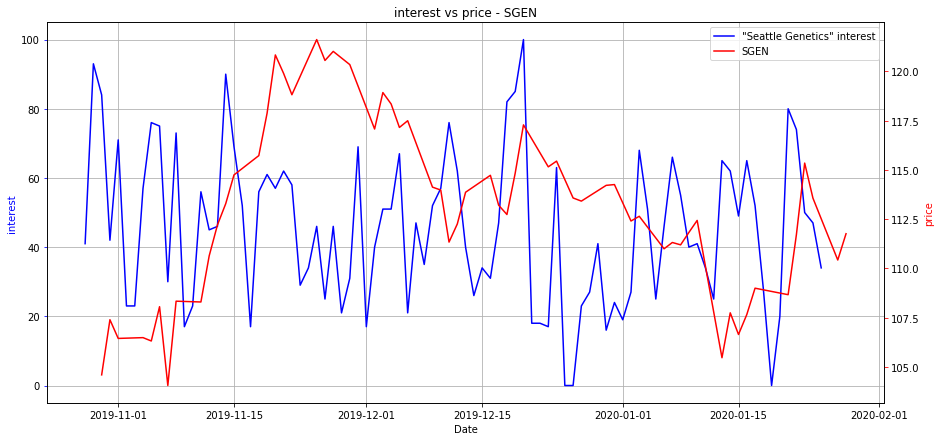

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


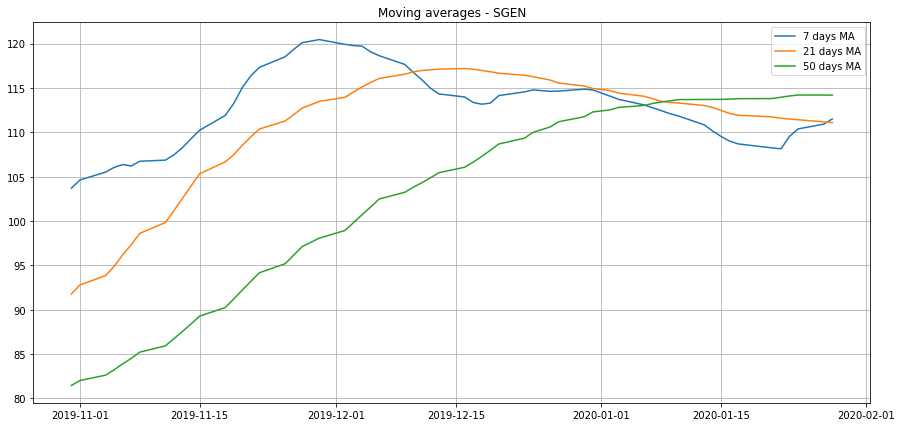

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-10-30  104.099998  106.389999  102.019997  104.599998  104.599998   
 2019-10-31  104.129997  107.459999  103.269997  107.400002  107.400002   
 2019-11-01  107.480003  107.550003  105.510002  106.449997  106.449997   
 2019-11-04  106.900002  107.849998  106.150002  106.489998  106.489998   
 2019-11-05  107.070000  107.190002  105.779999  106.320000  106.320000   
 ...                ...         ...         ...         ...         ...   
 2020-01-22  108.860001  111.790001  108.110001  111.720001  111.720001   
 2020-01-23  111.900002  115.750000  111.000000  115.349998  115.349998   
 2020-01-24  115.180000  118.660004  112.290001  113.570000  113.570000   
 2020-01-27  112.199997  112.529999  108.870003  110.430000  110.430000   
 2020-01-28  111.709999  112.919998  110.750000  111.764999  111.764999   
 
              Volume  


In [7]:
gtrend_vs_ma("SGEN", "Seattle Genetics")

# Smith & Nephew

[*********************100%***********************]  1 of 1 completed


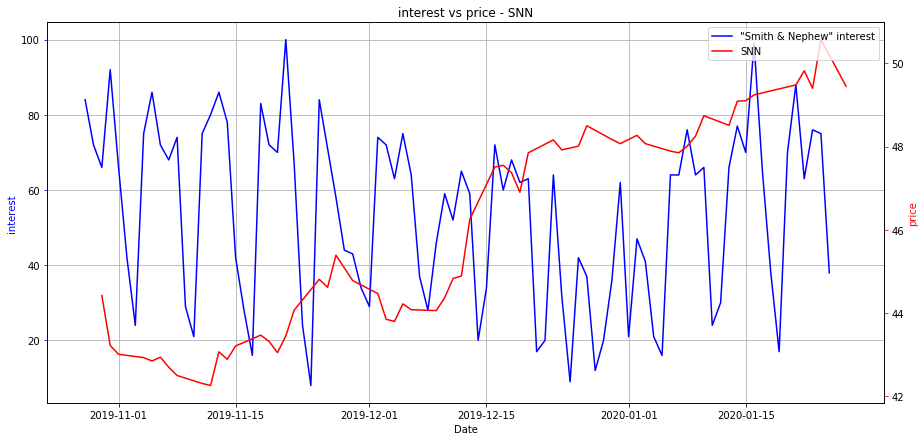

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


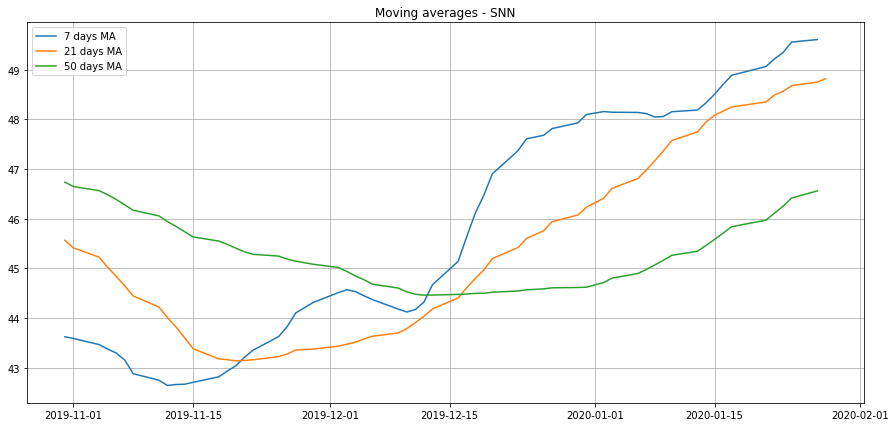

(                 Open       High        Low      Close  Adj Close   Volume
 Date                                                                      
 2019-10-30  44.119999  44.480000  43.990002  44.419998  44.419998   589300
 2019-10-31  43.689999  43.810001  42.520000  43.220001  43.220001  1571400
 2019-11-01  43.150002  43.439999  43.009998  43.009998  43.009998   638400
 2019-11-04  43.169998  43.189999  42.919998  42.930000  42.930000   419800
 2019-11-05  42.840000  42.970001  42.669998  42.849998  42.849998   482000
 2019-11-06  42.959999  43.020000  42.840000  42.939999  42.939999   459100
 2019-11-07  43.169998  43.180000  42.650002  42.700001  42.700001   387000
 2019-11-08  42.610001  42.810001  42.340000  42.500000  42.500000   477100
 2019-11-11  41.889999  42.500000  41.840000  42.310001  42.310001   870500
 2019-11-12  42.259998  42.450001  42.099998  42.259998  42.259998   622600
 2019-11-13  42.630001  43.180000  42.549999  43.070000  43.070000   402800
 2019-11-14 

In [8]:
gtrend_vs_ma("SNN", "Smith & Nephew")

# Boeing

[*********************100%***********************]  1 of 1 downloaded


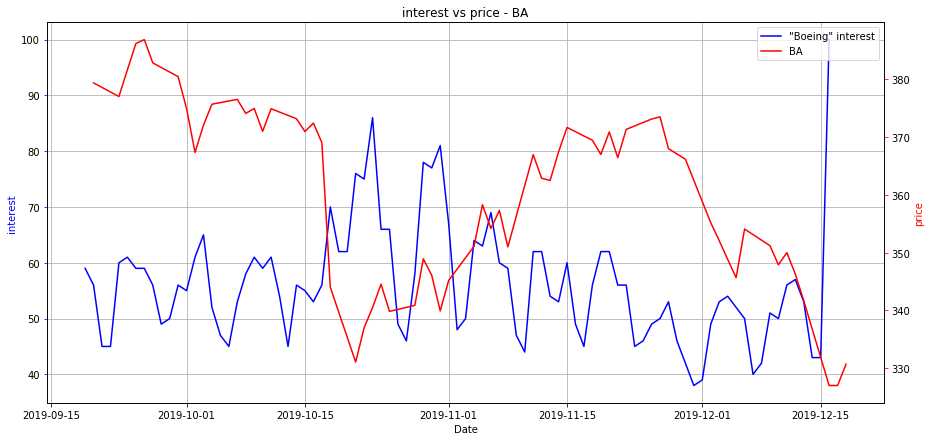

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


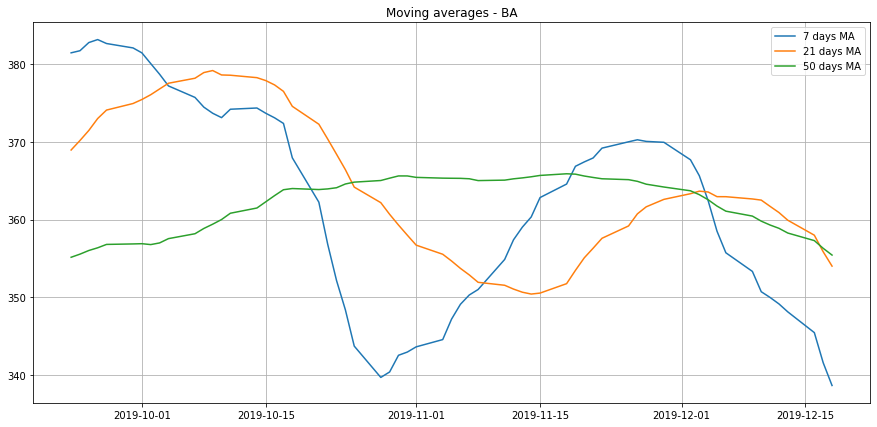

(              Open    High     Low   Close  Adj Close    Volume
 Date                                                           
 2019-09-20  384.11  384.73  377.92  379.39     377.19   6643000
 2019-09-23  376.61  380.10  374.42  377.03     374.84   2674900
 2019-09-24  379.54  381.89  375.31  381.65     379.44   3533300
 2019-09-25  384.91  391.00  383.10  386.20     383.96   4705500
 2019-09-26  387.10  388.23  383.33  386.89     384.65   2520400
 ...            ...     ...     ...     ...        ...       ...
 2019-12-12  348.25  351.07  341.00  346.29     346.29   5970000
 2019-12-13  346.30  349.31  341.10  341.67     341.67   4526300
 2019-12-16  328.53  336.23  326.43  327.00     327.00  16488200
 2019-12-17  322.06  330.95  320.61  327.00     327.00  13526400
 2019-12-18  328.72  335.25  328.14  330.68     330.68   7029300
 
 [63 rows x 6 columns],             /m/0178g  isPartial
 date                           
 2019-09-19        59      False
 2019-09-20        56      Fals

In [15]:
gtrend_vs_ma("BA", "Boeing")

# Peloton

[*********************100%***********************]  1 of 1 downloaded


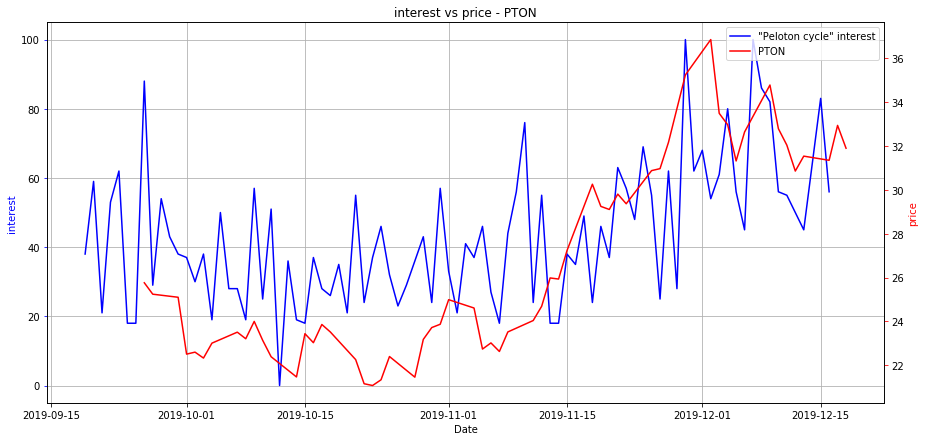

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


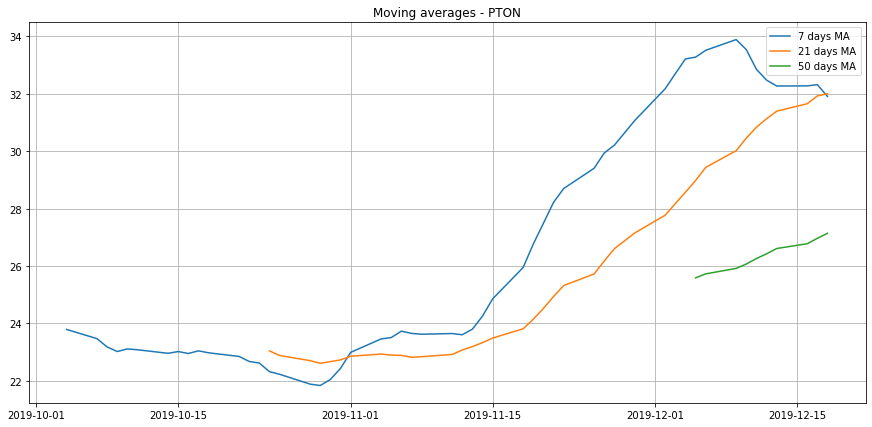

(             Open   High    Low  Close  Adj Close    Volume
 Date                                                       
 2019-09-26  27.00  27.98  24.75  25.76      25.76  47035200
 2019-09-27  26.17  26.17  23.75  25.24      25.24  15961500
 2019-09-30  25.26  25.85  25.00  25.10      25.10   4476700
 2019-10-01  25.00  25.17  22.51  22.51      22.51   8808700
 2019-10-02  22.25  23.18  21.76  22.60      22.60   9453600
 2019-10-03  22.49  22.82  21.14  22.33      22.33   8278000
 2019-10-04  22.35  23.42  22.31  23.01      23.01   3228900
 2019-10-07  23.07  24.33  22.49  23.51      23.51   2741400
 2019-10-08  23.60  23.90  22.33  23.21      23.21   2902100
 2019-10-09  23.63  24.80  23.25  24.00      24.00   3165600
 2019-10-10  24.10  24.20  22.80  23.14      23.14   3490300
 2019-10-11  23.10  23.40  22.11  22.39      22.39   3394900
 2019-10-14  22.17  22.28  21.40  21.47      21.47   2651100
 2019-10-15  21.51  23.68  21.51  23.44      23.44   2871400
 2019-10-16  23.54  23.5

In [16]:
gtrend_vs_ma("PTON", "Peloton cycle", use_sugg=False)

# AMD

[*********************100%***********************]  1 of 1 downloaded


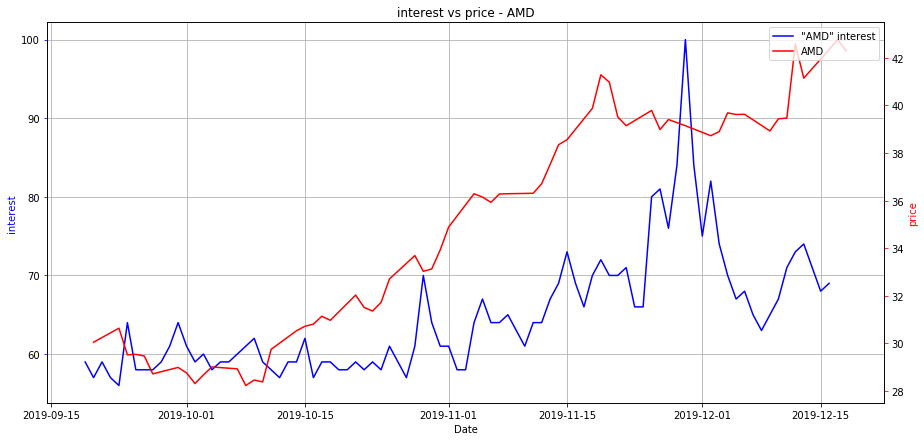

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


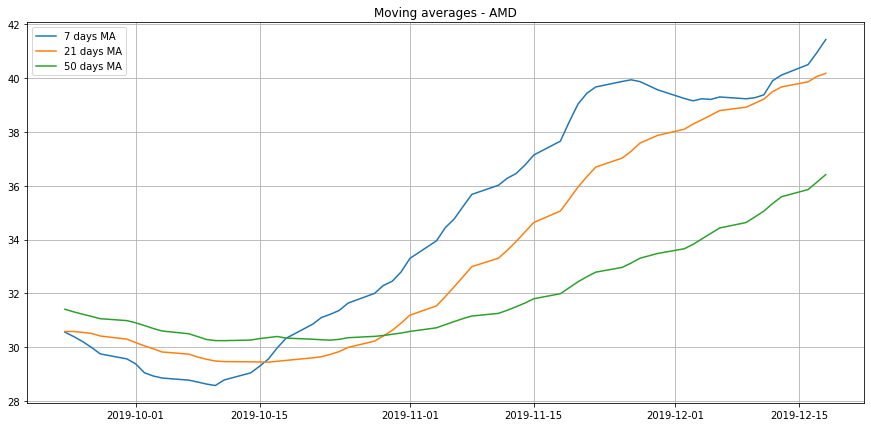

(             Open   High    Low  Close  Adj Close    Volume
 Date                                                       
 2019-09-20  30.36  30.47  29.65  30.05      30.05  79957400
 2019-09-23  30.12  30.80  30.07  30.64      30.64  44366800
 2019-09-24  30.54  30.75  29.29  29.52      29.52  72963000
 2019-09-25  29.48  29.65  28.55  29.54      29.54  58234800
 2019-09-26  29.67  29.77  29.00  29.47      29.47  40745400
 ...           ...    ...    ...    ...        ...       ...
 2019-12-12  39.40  42.62  39.25  42.59      42.59  86878000
 2019-12-13  42.35  42.95  41.06  41.15      41.15  79927800
 2019-12-16  41.73  42.98  41.73  42.35      42.35  58824900
 2019-12-17  42.51  43.11  42.15  42.77      42.77  44852000
 2019-12-18  42.79  43.06  42.24  42.30      42.30  39083300
 
 [63 rows x 6 columns],             /m/0z64  isPartial
 date                          
 2019-09-19       59      False
 2019-09-20       57      False
 2019-09-21       59      False
 2019-09-22       57  

In [17]:
gtrend_vs_ma("AMD", "AMD")

# D'ieteren

[*********************100%***********************]  1 of 1 downloaded


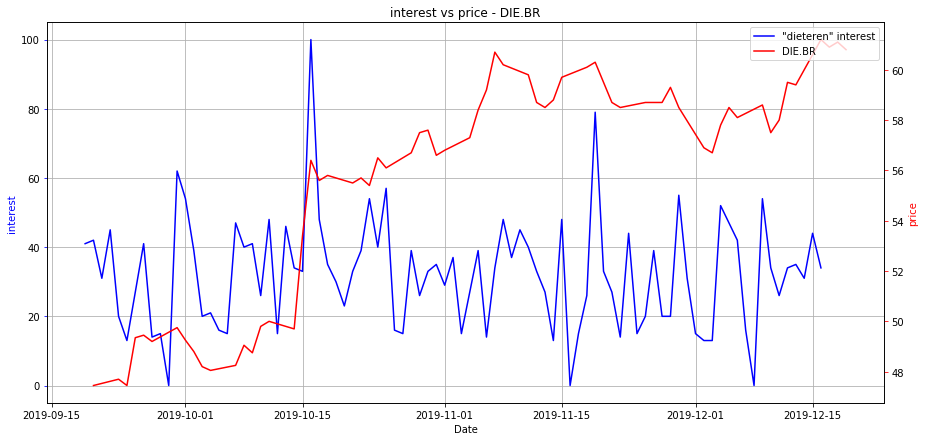

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


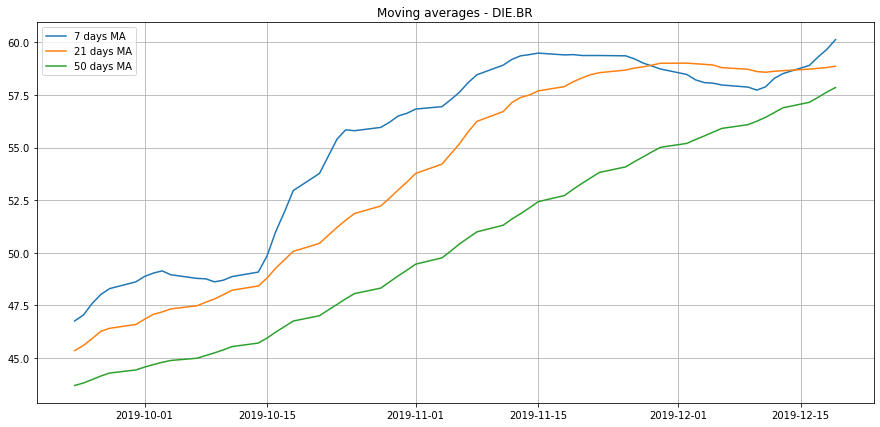

(             Open   High    Low  Close  Adj Close  Volume
 Date                                                     
 2019-09-20  47.60  47.95  47.30  47.45      47.45   73503
 2019-09-23  47.45  47.75  47.10  47.70      47.70   59254
 2019-09-24  47.60  48.00  47.45  47.45      47.45   60696
 2019-09-25  47.55  49.75  47.20  49.35      49.35  151857
 2019-09-26  49.45  50.20  49.20  49.45      49.45  112064
 ...           ...    ...    ...    ...        ...     ...
 2019-12-13  59.60  60.30  58.90  59.40      59.40   53135
 2019-12-16  59.70  61.50  59.20  61.20      61.20   57151
 2019-12-17  61.20  61.20  60.10  60.90      60.90   31569
 2019-12-18  60.60  61.30  60.60  61.10      61.10   37648
 2019-12-19  60.90  61.40  60.80  60.80      60.80   22389
 
 [65 rows x 6 columns],             dieteren  isPartial
 date                           
 2019-09-19        41      False
 2019-09-20        42      False
 2019-09-21        31      False
 2019-09-22        45      False
 2019-09-2

In [18]:
gtrend_vs_ma("DIE.BR", "dieteren", use_sugg=False)

# AB-Inbev

[*********************100%***********************]  1 of 1 downloaded


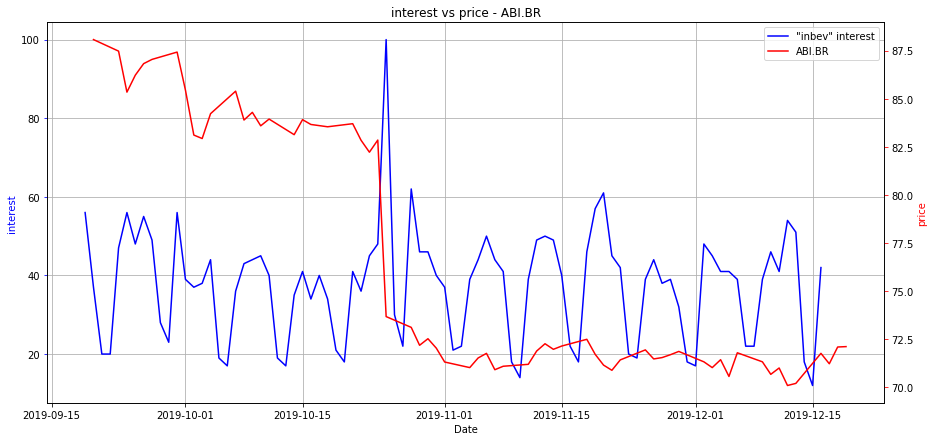

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


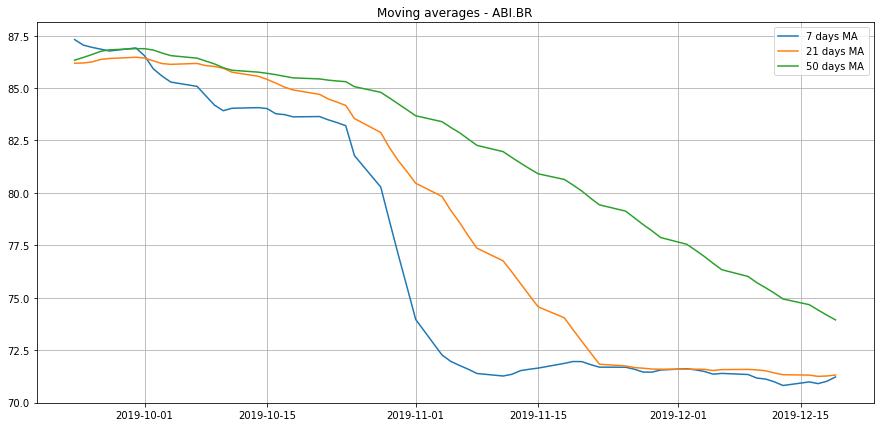

(             Open   High    Low  Close  Adj Close   Volume
 Date                                                      
 2019-09-20  86.62  88.07  85.64  88.07      87.10  4625677
 2019-09-23  87.18  87.84  87.04  87.47      86.50  1377025
 2019-09-24  87.04  87.44  85.34  85.34      84.40  1474518
 2019-09-25  84.72  86.75  84.56  86.22      85.27  1355375
 2019-09-26  85.35  87.06  85.35  86.82      85.86   837450
 ...           ...    ...    ...    ...        ...      ...
 2019-12-13  69.50  70.85  68.92  70.21      70.21  1814075
 2019-12-16  70.66  71.99  70.52  71.77      71.77  1676623
 2019-12-17  71.48  71.79  71.04  71.23      71.23  1921831
 2019-12-18  71.01  72.89  71.01  72.10      72.10  1835740
 2019-12-19  72.02  72.61  71.86  72.12      72.12   524710
 
 [65 rows x 6 columns],             inbev  isPartial
 date                        
 2019-09-19     56      False
 2019-09-20     37      False
 2019-09-21     20      False
 2019-09-22     20      False
 2019-09-23    

In [19]:
gtrend_vs_ma("ABI.BR", "inbev", use_sugg=False)

[*********************100%***********************]  1 of 1 downloaded


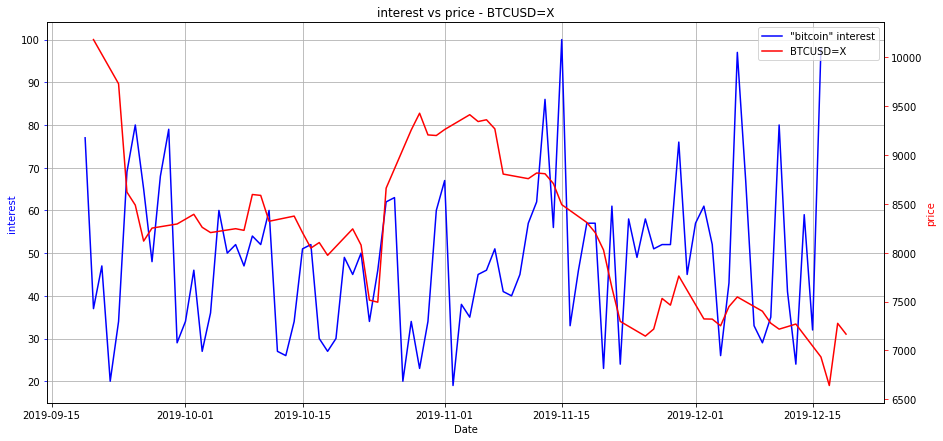

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


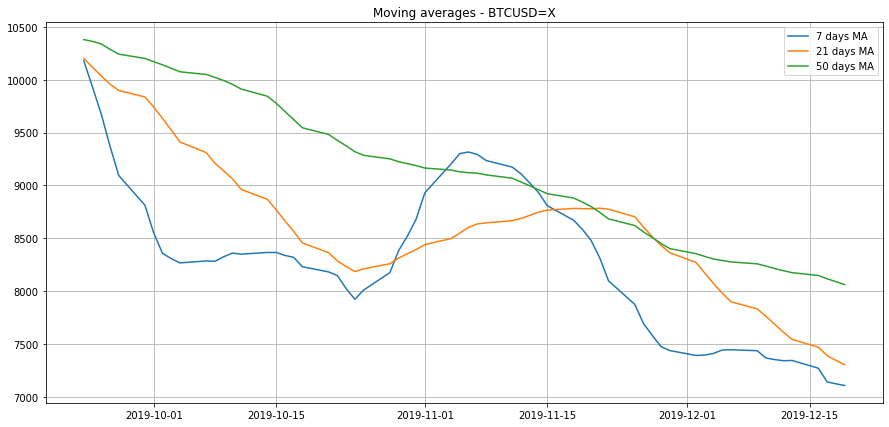

(                  Open        High         Low       Close   Adj Close  Volume
 Date                                                                          
 2019-09-20  10266.3184  10132.1846  10285.8760  10181.6406  10181.6406       0
 2019-09-23  10067.9590   9727.1445  10074.2363   9729.3203   9729.3203       0
 2019-09-24   9729.3203   8370.7998   9804.3154   8620.5635   8620.5635       0
 2019-09-25   8603.4307   8325.3965   8744.8281   8486.9902   8486.9902       0
 2019-09-26   8487.6670   7895.6323   8515.6826   8118.9658   8118.9658       0
 ...                ...         ...         ...         ...         ...     ...
 2019-12-13   7244.6602   7227.1201   7293.5630   7269.6821   7269.6821       0
 2019-12-16   7153.6641   6903.6841   7171.1685   6932.4814   6932.4814       0
 2019-12-17   6931.3135   6587.9756   6964.0747   6640.5166   6640.5166       0
 2019-12-18   6647.6987   6540.0513   7324.9824   7276.8022   7276.8022       0
 2019-12-19   7293.7627   7346.6021   70

In [20]:
gtrend_vs_ma("BTCUSD=X", "bitcoin")

# Draft

[*********************100%***********************]  1 of 1 downloaded


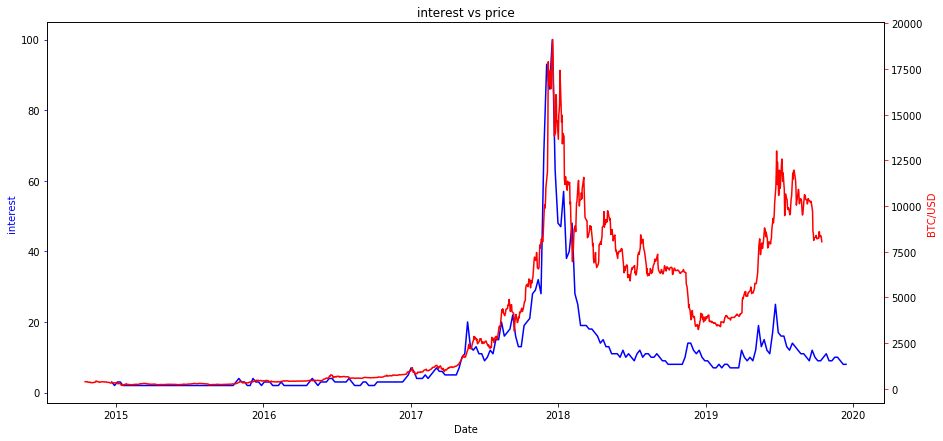

In [21]:
stock_df = yf.download("BTCUSD=X", start="2014-10-17", end="2019-10-17")


pytrend.build_payload(kw_list=['bitcoin'], cat=0, timeframe='today 5-y', geo='', gprop='') #creating payload  -> only for interest_over_time(), interest_by_region() & related_queries()
interest_over_time_df = pytrend.interest_over_time()

fig, ax1 = plt.subplots(figsize=(15,7))
ax1.set_title("interest vs price")
ax1.set_xlabel("Date")

ax1Color = "blue"
ax1.set_ylabel("interest", color=ax1Color)
ax1.plot(interest_over_time_df["bitcoin"], color=ax1Color)
ax1.tick_params(axis="y", color=ax1Color)

ax2 = ax1.twinx()
ax2Color = "red"
ax2.set_ylabel("BTC/USD", color=ax2Color)
ax2.plot(stock_df["Close"], color=ax2Color)
ax2.tick_params(axis="y", color=ax2Color)

plt.show()

In [22]:
# Interest by Region
interest_by_region_df = pytrend.interest_by_region()
print(interest_by_region_df.head())

# Related Queries, returns a dictionary of dataframes
related_queries_dict = pytrend.related_queries()
print(related_queries_dict)

# Get Google Hot Trends data
trending_searches_df = pytrend.trending_searches()
print(trending_searches_df.head())

# Get Google Hot Trends data
today_searches_df = pytrend.today_searches()
print(today_searches_df.head())

# Get Google Top Charts
top_charts_df = pytrend.top_charts(2018, hl='en-US', tz=300, geo='GLOBAL')
print(top_charts_df.head())

# Get Google Keyword Suggestions
suggestions_dict = pytrend.suggestions(keyword='pizza')
print(suggestions_dict)

                bitcoin
geoName                
Afghanistan           0
Albania               0
Algeria              10
American Samoa        0
Andorra               0
{'bitcoin': {'top':                 query  value
0       price bitcoin    100
1         bitcoin usd     20
2        bitcoin news     13
3        kurs bitcoin     12
4      usd to bitcoin     12
5         bitcoin buy     11
6         buy bitcoin     11
7      bitcoin mining     11
8        bitcoin cash     10
9     what is bitcoin      9
10      bitcoin value      9
11                btc      9
12  bitcoin price usd      9
13     bitcoin wallet      8
14           ethereum      8
15         bitcoin de      7
16       free bitcoin      7
17      bitcoin stock      7
18      bitcoin today      7
19      bitcoin chart      6
20       euro bitcoin      6
21           litecoin      5
22           bitcoins      5
23   price of bitcoin      5
24           coinbase      5, 'rising':                                                